In [1]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [2]:
out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'UV_tracking_fesom'

In [3]:
pwd

'/gxfs_work/geomar/smomw662/FESOMparcels_first/notebooks'

In [4]:
ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 36MB
Dimensions:     (trajectory: 1000, obs: 1800)
Coordinates:
  * obs         (obs) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 7MB 8.168 8.153 8.133 ... 10.81 10.81
    lon         (trajectory, obs) float32 7MB 2.461 2.434 2.407 ... 1.704 1.722
    time        (trajectory, obs) datetime64[ns] 14MB 2005-01-01T23:50:00 ......
    z           (trajectory, obs) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [5]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

## This function calculates the intermediate points on a straight line between two points
## Starting point (x0,y0) and end points (X1,Y1)

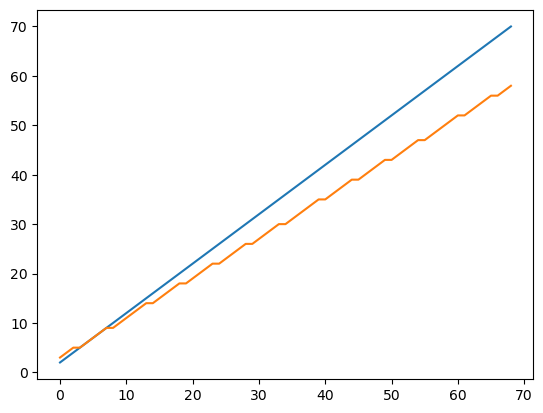

In [6]:
plt.plot(line_between((2,3),(70,58)))
#this function works for 2 points

In [7]:
def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)
    

In [8]:
## example of the forloop that looks into elements but not into indices
pairs = [(1,2),(5,8),(9,3)]
for a,b in pairs:
    print(a,b)


1 2
5 8
9 3


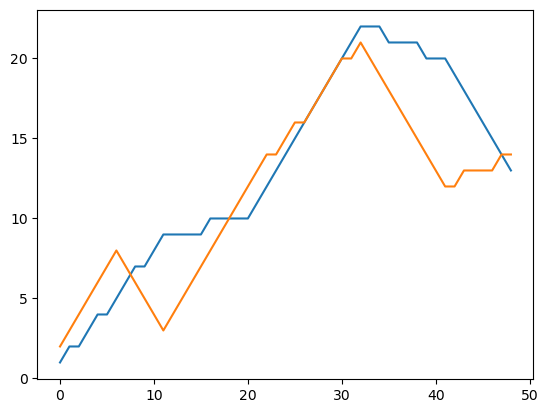

In [9]:
points = [(1,2),(5,8),(9,3), (10,12),(22,21),(20,12),(13,14)]
all_points = line_between_sequence(points)
plt.plot(all_points)
#this one works for all the points

In [10]:
#ds_traj.lon.diff('obs') < -4 # true for all the diff lesser than -4
#ds_traj.lon.diff('obs') > 4 # true for all the diff bigger than 4

4.5 * (ds_traj.lon.diff('obs') < -4)

<xarray.DataArray 'lon' (trajectory: 1000, obs: 1799)> Size: 14MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * obs         (obs) int32 7kB 1 2 3 4 5 6 7 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999

### Example 1

In [11]:
lon_try = np.array([3,2,1,0,4.5,3]) #west propagation
np.diff(lon_try)

array([-1. , -1. , -1. ,  4.5, -1.5])

In [12]:
4.5 * (np.diff(lon_try) > 4.0) #condition for west propagation

array([0. , 0. , 0. , 4.5, 0. ])

In [13]:
4.5*(np.diff(lon_try) < -4) #condition for east propagation

array([0., 0., 0., 0., 0.])

In [14]:
adlon = 0 + 4.5*(np.diff(lon_try) < -4) - 4.5 * (np.diff(lon_try) > 4.0)
adlon

array([ 0. ,  0. ,  0. , -4.5,  0. ])

In [15]:
np.cumsum(adlon)

array([ 0. ,  0. ,  0. , -4.5, -4.5])

In [16]:
ds_traj.lon[0]

<xarray.DataArray 'lon' (obs: 1800)> Size: 7kB
array([2.461119 , 2.4336767, 2.4073448, ..., 3.677522 , 3.707616 ,
       3.7378364], dtype=float32)
Coordinates:
  * obs         (obs) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
    trajectory  int64 8B 0
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

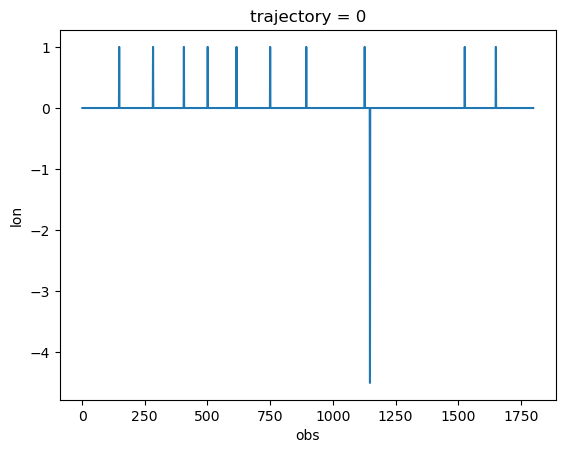

In [17]:
adlon = 0 + (ds_traj.lon[0].diff('obs') < -4) - 4.5 * (ds_traj.lon[0].diff('obs') > 4)
adlon.plot()

In [18]:
adlon.cumsum('obs')
#you need to add +4.5 (or subtract -4.5) 
#to all subsequent points, not just the point at the index of the big jump.
#This way they are all affected

<xarray.DataArray 'lon' (obs: 1799)> Size: 14kB
array([0. , 0. , 0. , ..., 5.5, 5.5, 5.5])
Coordinates:
  * obs         (obs) int32 7kB 1 2 3 4 5 6 7 ... 1794 1795 1796 1797 1798 1799
    trajectory  int64 8B 0

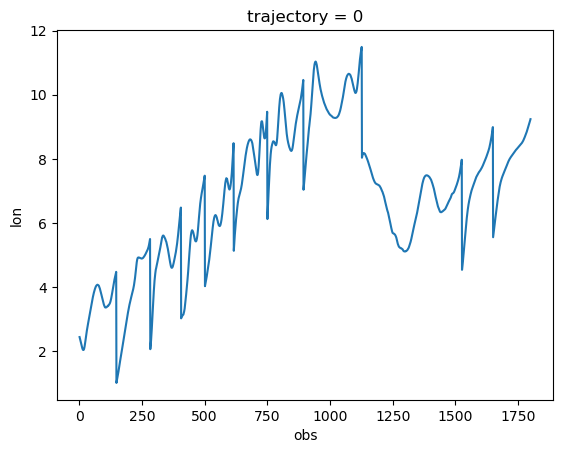

In [19]:
lonunroll = (ds_traj.lon[0] + adlon.cumsum('obs'))
lonunroll.plot()

### Unroll

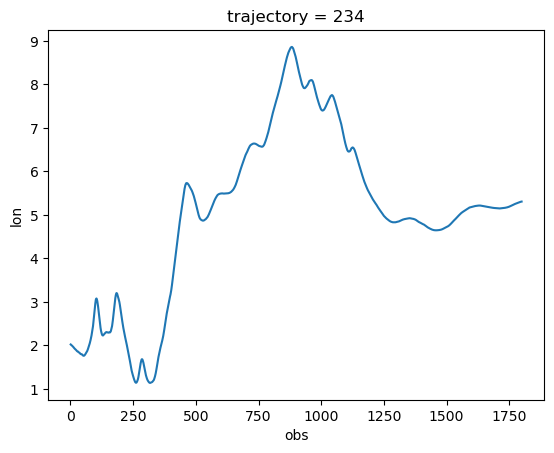

In [20]:
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
lon_unrolled.isel(trajectory=234).plot()

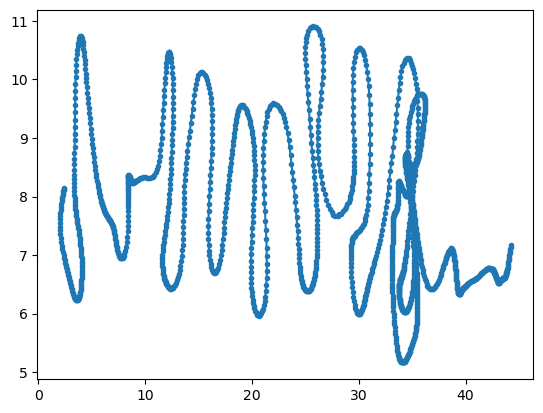

In [21]:
plt.plot(
    *xr.align(
        lon_unrolled.isel(trajectory=0),
        ds_traj.lat.isel(trajectory=0),
    ),
    '.-',
)

In [22]:
Nx = 45 #~4.5
Ny = 180 #~18.0

In [23]:
4.6 // 4.5 #floor division 

1.0

In [24]:
print(lon_unrolled.min().compute().data[()] // 4.5)
print(lon_unrolled.max().compute().data[()] // 4.5 +1)

-2.0
19.0


## Enumerate the ghost images in lon direction: (The one with number 1 is the real one)

In [25]:
#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_replica_lon

(-2.0, 19.0)

## Get the pixel numbers of the ghost pixels in x direction

In [26]:
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)
pix_x_unrolled

array([-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78,
       -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65,
       -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52,
       -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39,
       -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  9

In [27]:
pix_x_unrolled % Nx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44,  0

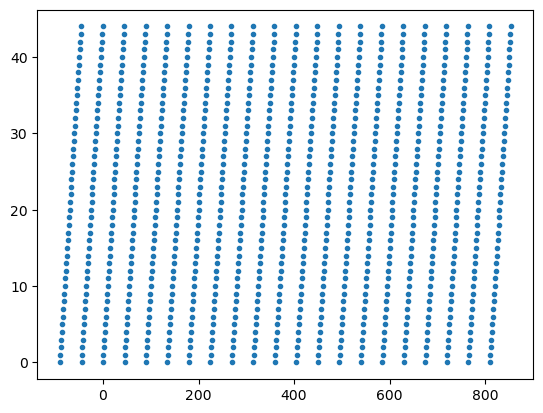

In [28]:
plt.plot(pix_x_unrolled, pix_x_unrolled % Nx,'.') #number of pixels of the ghosts 

In [29]:
lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds, lat_bds

((-9, 85), (0, 18))

In [30]:
from itertools import zip_longest
from functools import reduce
from operator import add
import tqdm

In [31]:
ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
#ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data
#ds_traj.trajectory.data

In [32]:
dens = np.zeros((Ny,Nx), dtype=int)

for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Nx,Ny]
    dens[*pos.T[::-1]] +=count
    #break

100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 177.30it/s]


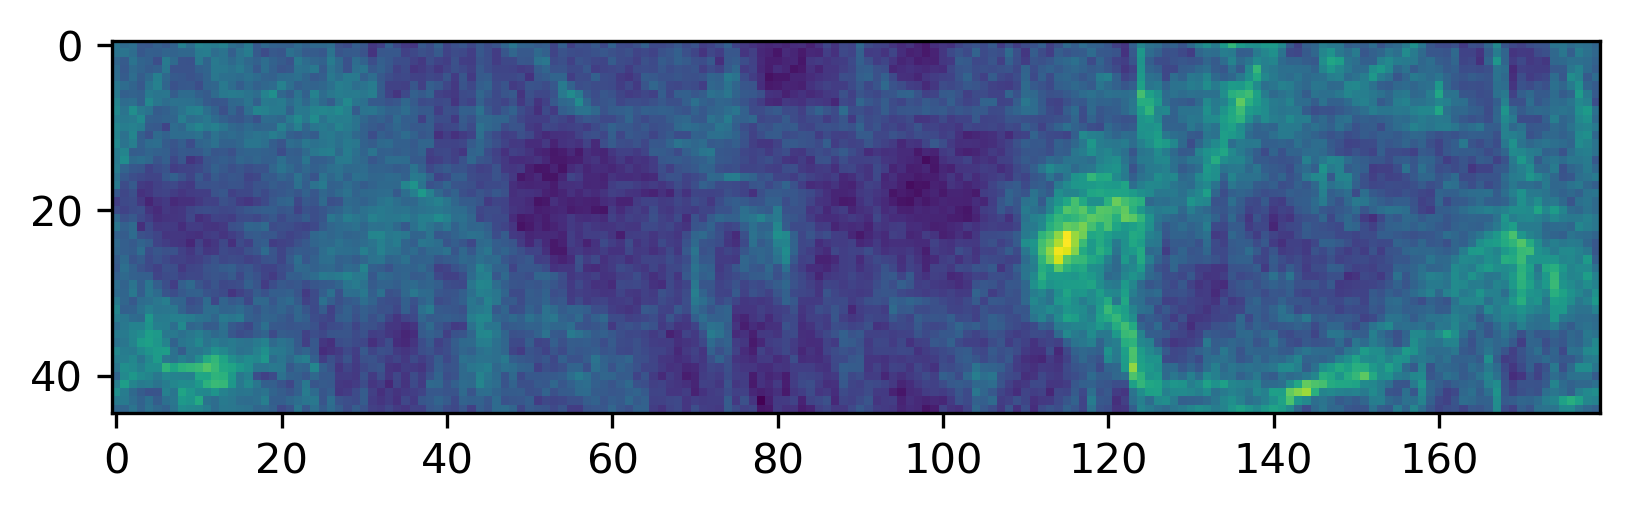

In [37]:
fig, ax = plt.subplots(1,1)
fig.set_dpi(300)
ax.imshow(dens)

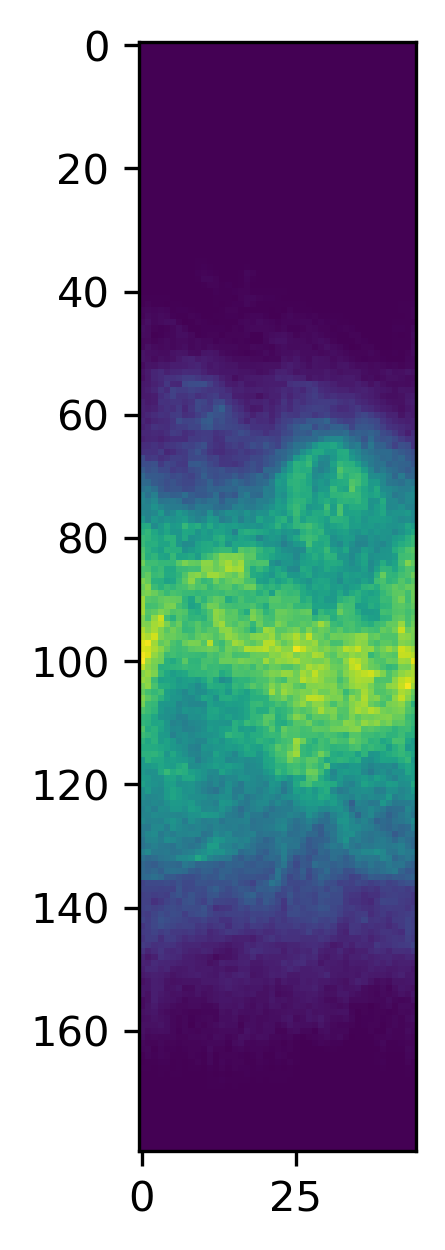

In [33]:
fig, ax = plt.subplots(1,1)
fig.set_dpi(300)
ax.imshow(dens)